In [62]:
import numpy as np
from numpy import pi,cos,sin
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram
from qiskit.extensions import Initialize

In [63]:
def bellState(circ, a, b):
    circ.h(a) 
    circ.cx(a,b)
    return circ
       
def x_measurement(circ, qubit, cbit):
    circ.h(qubit)
    circ.measure(qubit, cbit)
    return circ

In [64]:
def DQG(qc,q_c0,q_c1,q_t,q_altr0,q_altr1,c_altr0,c_altr1):
    qc.reset(q_altr0)
    qc.reset(q_altr1)
    bellState(qc,q_altr0,q_altr1)
    qc.ccx(q_c0,q_c1,q_altr0)
    qc.measure(q_altr0,c_altr0)
    qc.x(q_altr1).c_if(c_altr0,1)
    qc.cx(q_altr1,q_t)
    x_measurement(qc,q_altr1,c_altr1)
    qc.cz(q_c0,q_c1).c_if(c_altr1,1)
    return qc

In [65]:
def Protocol(theta_A1,theta_A2,theta_B1,theta_B2):
    q = QuantumRegister(10, name="q") 
    qw = QuantumRegister(2, name="qw")
    
    M_alice = ClassicalRegister(2, name="m_a") 
    M_bob = ClassicalRegister(2, name="m_b")
    M_C = ClassicalRegister(2, name="m_c")
    M_w = ClassicalRegister(2, name="m_w")
    
    qc = QuantumCircuit(q,qw,M_alice,M_bob,M_w,M_C)
    
    #Step1:
    initial_state_A1 = [np.cos(theta_A1/2),np.sin(theta_A1/2)]
    initial_state_B1 = [np.cos(theta_B1/2),np.sin(theta_B1/2)]              
    qc.initialize(initial_state_A1, q[0])
    qc.initialize(initial_state_B1, q[9])
    
    initial_state_A2 = [np.cos(theta_A2/2),np.sin(theta_A2/2)]
    initial_state_B2 = [np.cos(theta_B2/2),np.sin(theta_B2/2)]
    qc.initialize(initial_state_A2, q[1])
    qc.initialize(initial_state_B2, q[8])
    
    bellState(qc, q[4], q[5])
    qc.barrier()
    
    #Step2:
    qc.cx(q[1],q[4])
    qc.cx(q[8],q[5])
    qc.h(q[1])
    qc.h(q[8])
    qc.barrier()
    qc = DQG(qc,q[0],q[4],q[3],qw[0],qw[1],M_w[0],M_w[1])
    qc.barrier()
    qc = DQG(qc,q[9],q[5],q[6],qw[0],qw[1],M_w[0],M_w[1])
    qc.barrier()
    qc = DQG(qc,q[0],q[1],q[2],qw[0],qw[1],M_w[0],M_w[1])
    qc.barrier()
    qc = DQG(qc,q[9],q[8],q[7],qw[0],qw[1],M_w[0],M_w[1])
    qc.barrier()
    qc.h(q[1])
    qc.h(q[8])
    qc.cx(q[1],q[4])
    qc.cx(q[8],q[5])
    qc.barrier()
    
    #Step3:
    qc.measure(q[2],M_alice[0])
    qc.measure(q[3],M_alice[1])
    qc.x(q[5]).c_if(M_alice[1],1)
    qc.z(q[5]).c_if(M_alice[0],1)
    qc.barrier(q)
    
    #Step4:
    qc.measure(q[7],M_bob[0])
    qc.measure(q[6],M_bob[1])
    qc.x(q[4]).c_if(M_bob[1],1)
    qc.z(q[4]).c_if(M_bob[0],1)
    qc.barrier(q)
    
    
    qc.measure(q[4],M_C[0])
    qc.measure(q[5],M_C[1])
    return qc
    

theta_A2 =  2.839802010394575
State_A2 =  0.1503233405616381 |0>+ 0.9886368864666085 |1>
theta_B2 =  1.0256143775942115
State_B2 =  0.871370665001253 |0>+ 0.4906252787772701 |1>


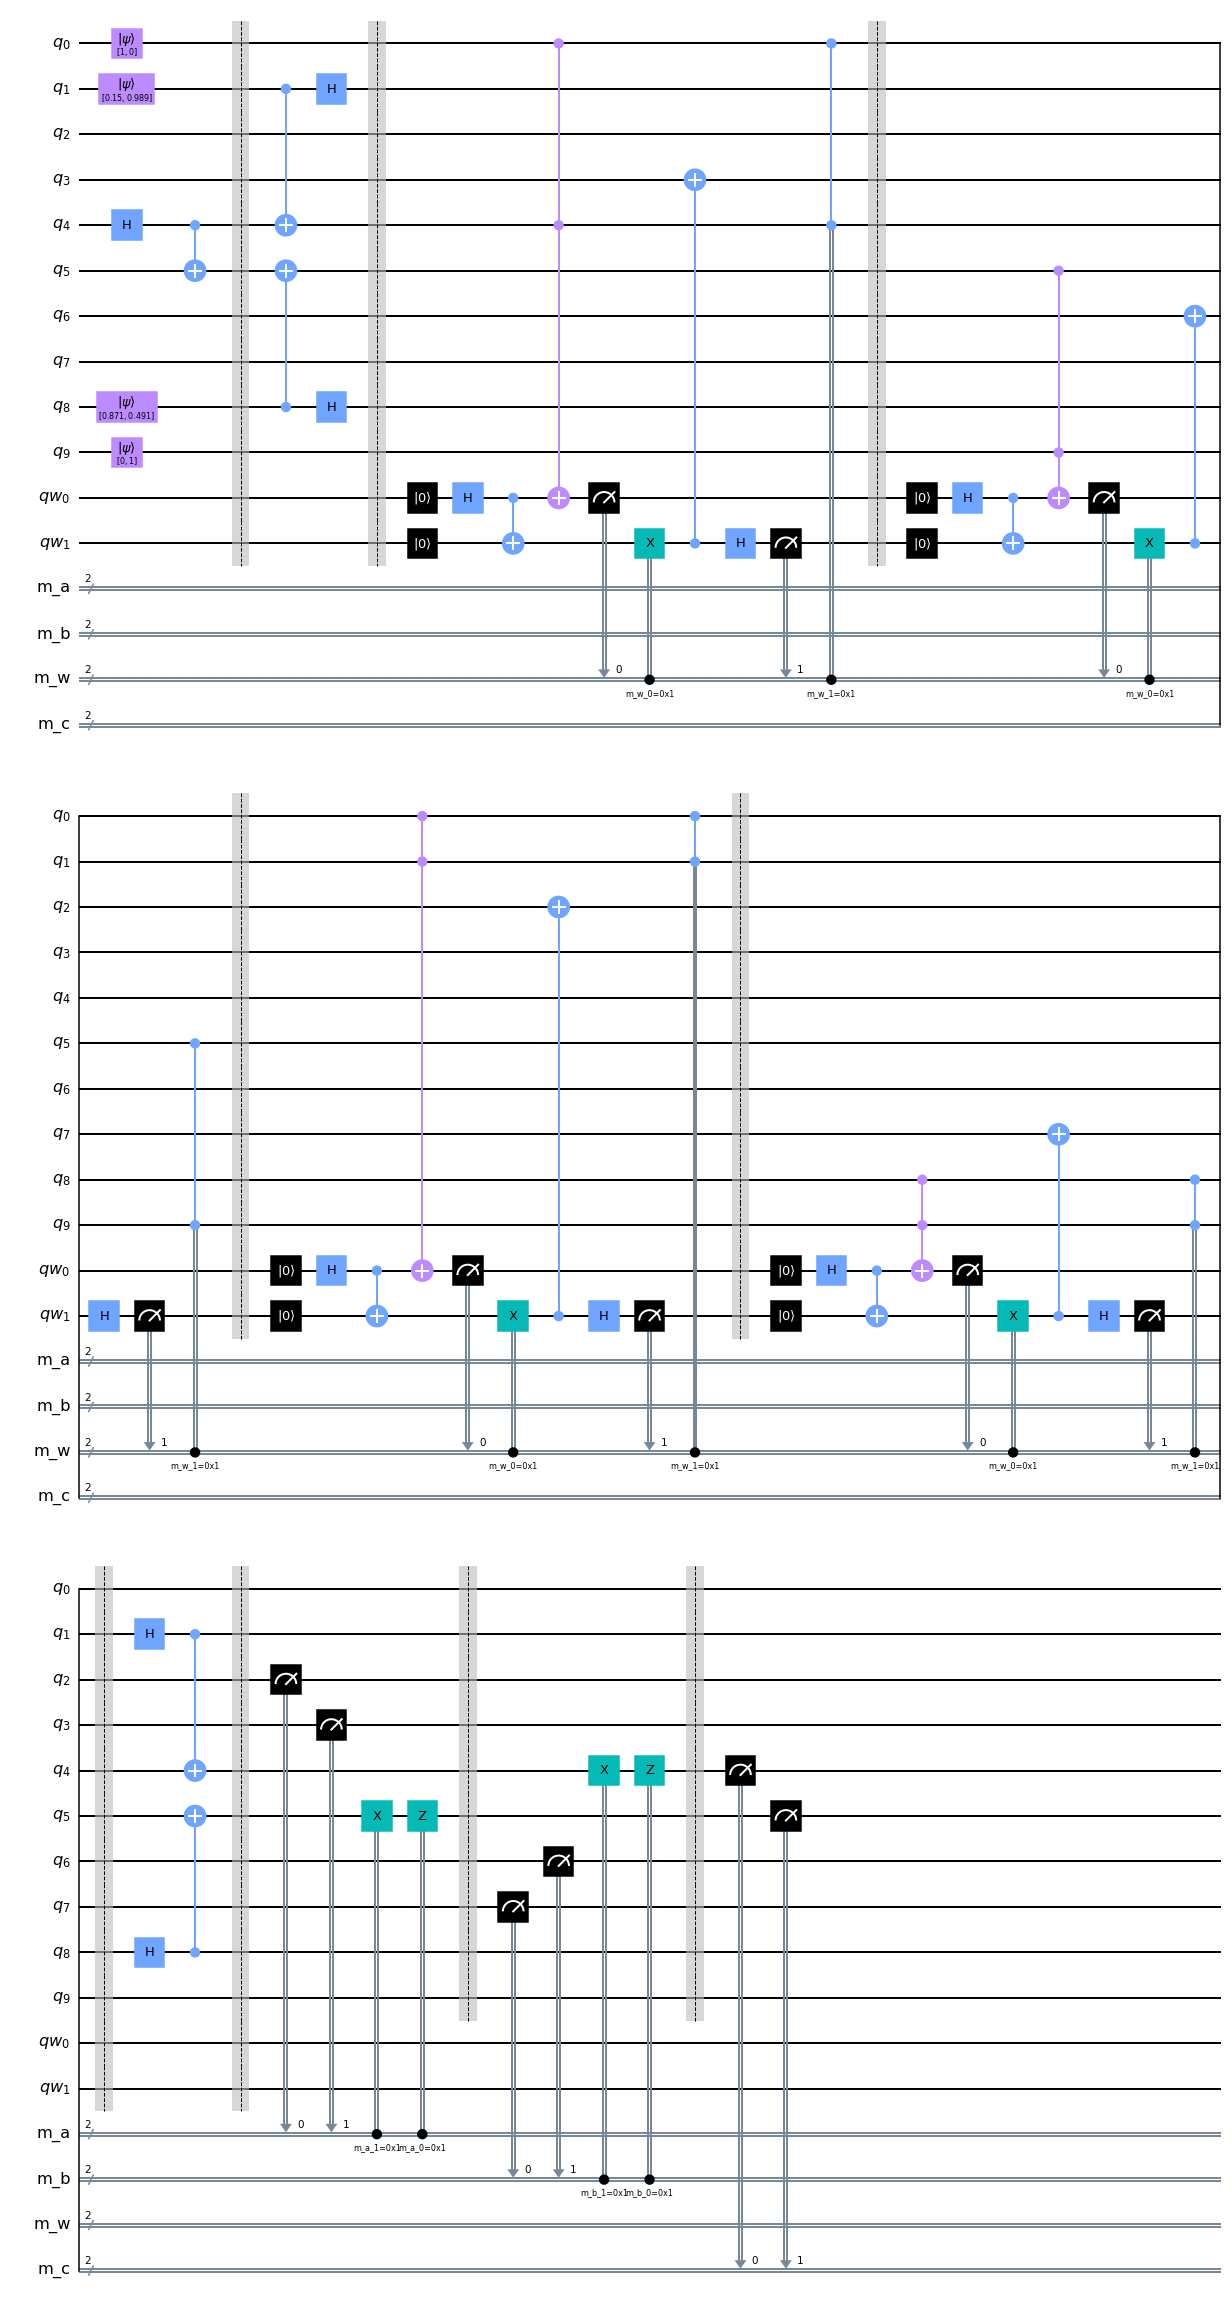

In [115]:
# Enable qubits
theta_A1 = 0
theta_B1 = pi
# Input qubits
theta_A2 = np.random.uniform(0,pi,size=(1,))
theta_B2 = np.random.uniform(0,pi,size=(1,))
print('theta_A2 = ',theta_A2[0])
print('State_A2 = ',cos(theta_A2[0]/2),'|0>+',sin(theta_A2[0]/2),'|1>')
print('theta_B2 = ',theta_B2[0])
print('State_B2 = ',cos(theta_B2[0]/2),'|0>+',sin(theta_B2[0]/2),'|1>')

# Run protocol
Qc = Protocol(theta_A1,theta_A2[0],theta_B1,theta_B2[0])
Qc.draw('mpl')

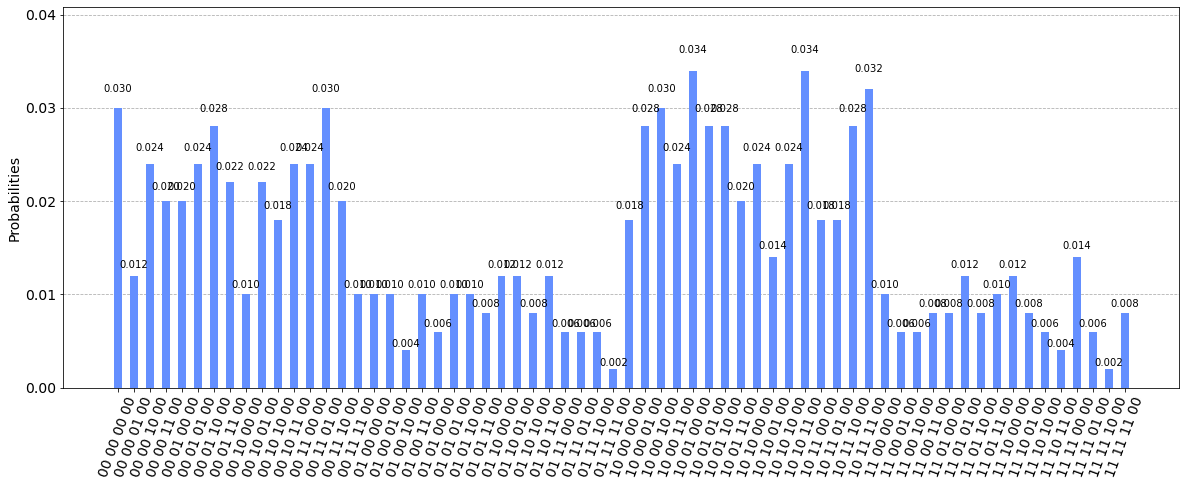

In [116]:
simulator = Aer.get_backend('qasm_simulator')
sim = transpile(Qc, simulator)

# Simulation with the 500 measurement shots 
result = simulator.run(sim, shots=500).result()
counts = result.get_counts(sim)

# Quantum system States
plot_histogram(counts,(20,7))

In [117]:
S = np.zeros([8])

for state in counts:    
    if (state[0]=='0')&(state[1]=='0'):
        S[4] = counts[state]
        S[0]=S[0]+counts[state]
        S[2]=S[2]+counts[state]
    if (state[0]=='0')&(state[1]=='1'):
        S[5] = counts[state]
        S[0]=S[0]+counts[state]
        S[3]=S[3]+counts[state]
    if (state[0]=='1')&(state[1]=='0'):
        S[6] = counts[state]
        S[1]=S[1]+counts[state]
        S[2]=S[2]+counts[state]
    if (state[0]=='1')&(state[1]=='1'):
        S[7] = counts[state]
        S[1]=S[1]+counts[state]
        S[3]=S[3]+counts[state]
        
count_CAB = {'00':S[4],'01':S[5],'10':S[6],'11':S[7]}
count_CA = {'0':S[0],'1':S[1]}
count_CB = {'0':S[2],'1':S[3]}

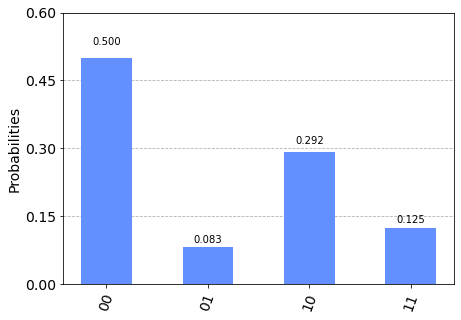

In [118]:
plot_histogram(count_CAB)

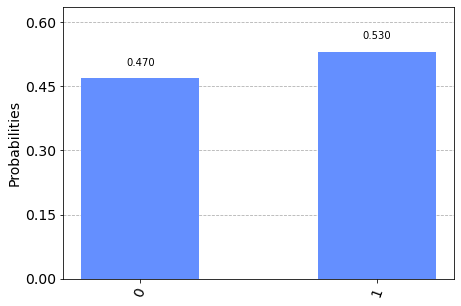

In [119]:
plot_histogram(count_CA)

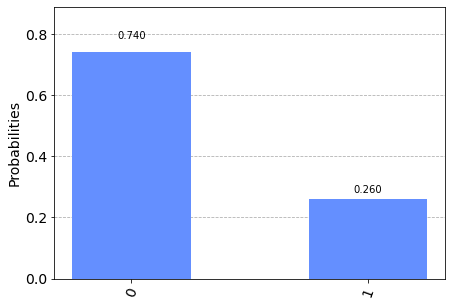

In [120]:
plot_histogram(count_CB)